In [1]:
import json
import pandas as pd
import numpy as np
from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
def load_dict_from_json(file_path):
    """
    Load content from file then parse it to dictionary

    Args:
        file_path (TYPE): Description

    Returns:
        TYPE: Description
    """
#     logger.debug('load_dict_to_json: %s', locals())
    data = {}
    with open(file_path, 'r') as file:
        text = file.read()
        temp = json.loads(text)
        data = temp
#         logger.debug('data: %s', data)

#     logger.debug('number of keys: %s', len(data))
    return data

def load_concept_definition(file_path):
    """Summary

    Args:
        file_path (TYPE): Description

    Returns:
        TYPE: Description

    No Longer Raises:
        e: Description
    """
    concepts = dict()
    data = load_dict_from_json(file_path)
    for f in data['definition']:
        conceptid = f['conceptid']
        concepts[conceptid] = dict()
        concepts[conceptid]['type'] = f['type']
        concepts[conceptid]['min_value'] = f['min_value']
        concepts[conceptid]['max_value'] = f['max_value']
        concepts[conceptid]['multiply'] = f['multiply']
        concepts[conceptid]['data'] = dict()
        for v in f['data']:
            concepts[conceptid]['data'][v['value']] = v['id']

        concepts[conceptid]['segments'] = dict()
        for s in f['segments']:
            concepts[conceptid]['segments'][s['value']] = s['id']

        concepts[conceptid]['hashmaps'] = dict()
        for h in f['hashmaps']:
            concepts[conceptid]['hashmaps'][h['value']] = h['hash']

    item2concept = dict()
    for c in data['item2concept']:
        item2concept[c['itemid']] = c['conceptid']

    return concepts, item2concept

In [3]:
# Test call shell script in Python
#!/usr/bin/python
import subprocess
def call_shell(filename):
    with open(filename, 'rb') as file:
        script = file.read()
    rc = subprocess.call(script, shell=True)

def call_shell(script):
    rc = subprocess.call(script, shell=True)


In [ ]:
# Generate QUERY_PATH
# itemids = [123456, 


# print("start")
# script = 'sleep 10\n'
# script += '../feature_transformation/feature2vec.exe print-feature-vectors %s %s %s' % (
#     MODEL_PATH, QUERY_PATH, OUTPUT_PATH)
# call_shell(script)
# print("end")

In [4]:
concepts_def, _ = load_concept_definition('../data/concept_definition.json')
# concepts_def[300003]

In [5]:
# CONSTANTS
MODEL_NAME = "skipgram_ce_nm_05M"
MODEL_PATH = '../models/%s.bin' % MODEL_NAME
OUTPUT_VEC_PATH = '../models/%s.vec' % MODEL_NAME

## Load vectors of features from OUTPUT_VEC_PATH


In [8]:
content = []
with open(OUTPUT_VEC_PATH) as f:
    content = f.readlines()
# remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

# the first line is: [number of feature] [dimension]
nb_feature, dim = content[0].split()
nb_feature = int(nb_feature)
dim = int(dim)
print('nb_feature: %s\ndim: %s' % (nb_feature, dim))

nb_feature: 12294
dim: 100


In [9]:
content[1]

'300001,3356228888,-0.58395 -0.03284 0.36123 -0.058787 0.30393 0.10599 -0.26872 0.10693 -0.35057 -0.09294 0.239 0.075657 0.014232 -0.12011 -0.3889 -0.25704 -0.39978 0.42794 0.27651 -0.049918 -0.16609 0.3126 -0.41953 0.52887 -0.42692 -0.016051 -0.024419 0.072918 -0.038326 0.092855 0.11552 -0.085042 -0.29981 0.28921 -0.39245 -0.20393 -0.030589 -0.3325 -0.13472 -0.024563 -0.0032178 -0.34488 0.41051 0.045124 0.11164 0.078869 -0.2236 0.16242 0.19733 0.15668 -0.36725 -0.015332 0.40591 0.56096 -0.093343 0.18661 0.58051 0.24461 0.25334 -0.18769 0.19698 -0.083105 0.1047 -0.050309 -0.060759 -0.31934 -0.02605 -0.043323 0.13165 0.28211 -0.2641 0.27547 -0.33006 -0.14847 -0.12159 -0.20631 -0.10068 0.061011 -0.093097 0.085649 0.01922 0.15706 -0.06737 -0.3675 0.053821 -0.54329 -0.045001 0.52168 0.29349 0.1732 0.18379 -0.084531 0.25761 0.25739 -0.011094 0.53182 0.18012 0.1224 -0.071183 -0.025661'

In [64]:
output_feature_dict = dict()
total_features = 0
oof_feature_dict = dict() # out of feature
for line in content[1:]:
    x = line.split(',')
    assert len(x) == 3, 'INVALID FORMAT: %s' % x
    
    conceptid = int(x[0])
    assert conceptid in concepts_def.keys(), 'conceptid=%s does not exist' % conceptid
    concept = concepts_def[conceptid]
        
    v = [float(i) for i in x[2].split()]
    assert len(v) == dim, "Dimension of vector is invalid"
    
    value = int(x[1])
    # 0 if is_number else 1
    if concept['type'] == 0:
        if value < concept['min_value']:
            value = concept['min_value'] - 1
        elif value > concept['max_value']:
            value = concept['max_value'] + 1
            
    # 
    if value not in concepts_def[conceptid]['data'].keys():
        print('cannot find index of conceptid=%s, value=%s\nLine: %s' % (
            conceptid, value, line))
        if conceptid not in oof_feature_dict.keys():
            oof_feature_dict[conceptid] = [value]
        else:
            oof_feature_dict[conceptid].append(value)
    else:
        if conceptid in output_feature_dict.keys():
            output_feature_dict[conceptid][value] = v
        else:
            output_feature_dict[conceptid] = dict()
            output_feature_dict[conceptid][value] = v
        total_features += 1

print('\nOut of features: %s' % oof_feature_dict.keys())
print('Number of concepts:', len(output_feature_dict.keys()))
print('Number of <concept, value>:', total_features)

count_concept_morethan3values = 0
for c_id in output_feature_dict.keys():
    if concepts_def[c_id]['type'] == 0 and len(output_feature_dict[c_id]) > 3:
        count_concept_morethan3values += 1
print('count_concept_morethan3values=', count_concept_morethan3values)


Out of features: dict_keys([])
Number of concepts: 1590
Number of <concept, value>: 12294
count_concept_morethan3values= 353


### 1. Experiments with numeric features

Difference between cosine_similarity and distance
```
a = np.array([1, 0, -1]).reshape(1, -1)
b = np.array([-1,-1, 0]).reshape(1, -1)
sim = cosine_similarity(a, b)[0][0]
print(sim)
print(np.linalg.norm(a-b))

-0.4999999999999999
2.449489742783178
```

In [85]:
def calculate_distances(conceptid, output_feature_dict):
    '''
    Check distances: for example, the original values are v1=10, v2=15, v3=16, v4=20
        d(v1, v4) > d(v1, v3) > d(v1, v2)
        * d is distance function
    then their corresponding vectors must keep the original distance: 
        d(vector_1, vector_4) > d(vector_1, vector_3) > d(vector_1, vector_2)
    '''
    if conceptid not in output_feature_dict.keys():
        # print('Conceptid=%s does not exist in definition' % conceptid)
        return None, None, None, None
    
    violate_distance = False
    
    # print('Concerned concept: id=%s' % (conceptid))
    vectors = [(value, np.array(vector).reshape(1, -1)) for value, vector in output_feature_dict[concerned_id].items()]
    vectors = sorted(vectors, key=itemgetter(0), reverse=False)
    # print('Sorted vectors', vectors)
    
    # calculate distance between each vector with the vector of min value
    distances = list()
    min_value, min_vector = vectors[0]
    for index, (value, vector) in enumerate(vectors):
        d = np.linalg.norm(vector - min_vector)
        distances.append(d)
        if len(distances) > 1:
            if distances[-1] < distances[-2]:
                violate_distance = True
#                 print('ERROR: Distance(%s, %s) is smaller than distance(%s, %s)' % (
#                     min_value, value, min_value, vectors[index-1][0]))

    # extract vectors and original values
    X = np.concatenate([vector for _, vector in vectors])
    y = np.array([value for value, _ in vectors])
    # print('X.shape:', X.shape)
    # print('y.shape:', y.shape)
    return X, y, violate_distance, distances

In [40]:
# visualize
def plot_MDS(*data, fname=None):
    '''
    graph after MDS
    :param data: train_data, train_value
    :return: None
    '''
    D, y = data
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    X_r = mds.fit_transform(D)

    ### graph
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # method 1
    plt.scatter(X_r[:, 0], X_r[:, 1])
    for i, txt in enumerate(y):
        ax.annotate(txt, (X_r[i, 0] + 0.05, X_r[i, 1] + 0.05))
    
    # method 2
#     colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),
#         (0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),)
#     for label ,color in zip( np.unique(y),colors):
#         position=y==label
#         ax.scatter(X_r[position,0],X_r[position,1],label="target= {0}".format(label),color=color)
#     ax.legend(loc="best")

    ax.set_xlabel("X[0]")
    ax.set_ylabel("X[1]")
    ax.set_title("MDS")
    plt.axis('equal')
    
    if fname is not None:
        plt.savefig(fname)
    plt.show()

In [83]:
concerned_id = 211
print('type=', concepts_def[concerned_id]['type'])
X, y, violate_distance, distances = calculate_distances(concerned_id, output_feature_dict)
print('Is violate?:', violate_distance)
print('distances: ', distances)

type= 0
Is violate?: True
distances:  [0.0, 1.2152402426624695, 0.7254141274748603, 0.8300446714248566, 1.0165293584436643, 1.3234448432596722, 0.8695235089537269, 0.8725296799906913, 0.7637272693781387, 0.7441477147685183, 1.1570892639442507, 1.133878660548737, 0.8221391763265378, 0.9706858175152546, 1.2286942823589715, 0.9490911934978998, 0.8519448258053206, 0.8985862514635522, 0.9089487213628273, 0.859767868730963, 0.8318940077359063, 0.9228392802246705, 1.0160356907532275, 0.97292136885184, 0.8984003266276055, 0.999034570411654, 0.8474925970743686, 0.905628874742588, 1.1288910688454783, 1.1395568348292673, 0.9714999442173542, 1.0957278547706535, 1.173600395003831, 1.1856876123422468, 1.1802324256160088, 1.0850660951232687, 1.1440595547853172, 1.302168029508727, 1.1717710234931686, 1.3352273339733416, 1.249681584904262, 1.2606827527037474, 1.198022731393344, 1.2495350915249515, 1.2423040972134254, 1.350633578562851, 1.3435324811724272, 1.2816428311193482, 1.4207227405620795, 1.46923

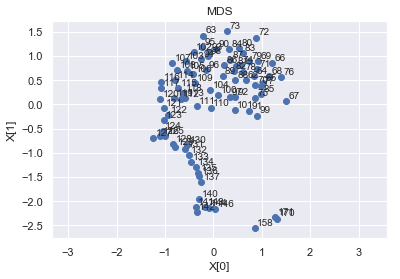

In [84]:
D = pairwise_distances(X)
plot_MDS(D, y, fname='%s.png' % concerned_id)

#### 1.1 Count number of numeric features violates distance

In [87]:
violated_concepts = list()
total_numeric_concepts = 0
for conceptid, concept in concepts_def.items():
    if concept['type'] == 0 and conceptid in output_feature_dict.keys():
        total_numeric_concepts += 1
        X, y, violate_distance, distances = calculate_distances(conceptid, output_feature_dict)
        if violate_distance is not None and violate_distance:
            violated_concepts.append(conceptid)
print('Number of violated concepts: %s/%s ~ %s percent \n\nViolated concept ids:%s' % (
    len(violated_concepts), total_numeric_concepts, 
    len(violated_concepts)*100./total_numeric_concepts, 
    violated_concepts)
     )

Number of violated concepts: 679/679 ~ 100.0 percent 

Violated concept ids:[300003, 300004, 1540, 443, 227449, 6186, 189, 225813, 225672, 227446, 224, 225641, 225175, 225313, 226457, 59, 224685, 226730, 223768, 224697, 791, 224328, 1520, 1286, 226108, 226063, 227073, 220293, 220088, 226537, 227461, 220624, 228098, 224562, 227867, 220061, 589, 52, 1695, 227368, 225103, 224643, 224966, 223835, 228232, 225124, 227351, 220274, 227439, 223901, 1530, 71, 223810, 8370, 224738, 512, 430, 227717, 220339, 228345, 227369, 1624, 224965, 920, 797, 226544, 497, 827, 495, 223761, 6185, 224331, 422, 220765, 858, 442, 1424, 662, 226135, 5814, 1742, 223821, 627, 227443, 814, 224916, 228102, 1127, 228337, 227538, 1162, 220051, 220050, 226534, 224710, 8449, 227345, 225636, 220228, 223834, 227465, 521, 436, 224055, 223769, 224056, 227809, 450, 802, 227356, 1528, 227357, 225112, 513, 227802, 803, 227923, 824, 224332, 817, 220060, 825, 490, 1616, 55, 224639, 224421, 227342, 224924, 225634, 224751, 220052, 1

#### 1.2 Check similarity between the dublicated concepts

ONLY apply for unmerged data

In [98]:
heart_rate = [211, 220045]
data = dict()
for idx in heart_rate:
    data[idx] = dict()
    for value, vector in output_feature_dict[idx].items():
        data[idx][value] = np.array(vector).reshape(1, -1)

for value, vector in data[heart_rate[0]].items():
    if value in data[heart_rate[1]].keys():
        co_vector = data[heart_rate[1]][value]
        print('similarity of %s: %s' % (value, cosine_similarity(vector, co_vector)[0][0]))

similarity of 62: 0.12472146534276216
similarity of 64: 0.12960925210011626
similarity of 67: 0.1552919154714634
similarity of 63: 0.06665541371163032
similarity of 66: 0.13262026013080247
similarity of 68: 0.1588435505412535
similarity of 76: 0.156003205551435
similarity of 65: 0.09338397517710817
similarity of 81: 0.1624014030519876
similarity of 72: 0.1565139652490925
similarity of 74: 0.15441502120130451
similarity of 94: 0.1193609574364727
similarity of 92: 0.15476815295303575
similarity of 89: 0.15410942257344482
similarity of 82: 0.13289666279414508
similarity of 87: 0.15254876455976132
similarity of 86: 0.15323139416918913
similarity of 88: 0.1573649028445233
similarity of 85: 0.10678591397652111
similarity of 84: 0.12270613361857156
similarity of 79: 0.1639438713965776
similarity of 80: 0.1284304996517447
similarity of 75: 0.10981498419346347
similarity of 73: 0.11770133396993393
similarity of 69: 0.13920949577061495
similarity of 78: 0.14869831182506568
similarity of 70: 0.13

### 2. Experiments with category features